## Projection in Graph

- Useful to investigate the relationships between nodes on one partition
    - Conditioned on the connections to the nodes in other partition

<img src="../../images/bipartite_example_projection.png" width="300" height="300">

Understanding the choice of products can help us understand the relationship between the customers

<img src="../../images/projection.png" width="400" height="400">

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
# import nxviz as nv
import numpy as np
from operator import itemgetter

In [7]:
df = pd.read_csv('../../data/network/american-revolution.csv', index_col=0)

In [8]:
df.head()

,StAndrewsLodge,LoyalNine,NorthCaucus,LongRoomClub,TeaParty,BostonCommittee,LondonEnemies
Adams.John,0,0,1,1,0,0,0
Adams.Samuel,0,0,1,1,0,1,1
Allen.Dr,0,0,1,0,0,0,0
Appleton.Nathaniel,0,0,1,0,0,1,0
Ash.Gilbert,1,0,0,0,0,0,0


In [9]:
df_new = pd.DataFrame()
i=0
for index in df.index:
    for column in df.columns:
        if df.loc[index, column] == 1:
            df_new.loc[i, 'people'] = index
            df_new.loc[i, 'club'] = column
            i+=1
        

In [10]:
df_new

,people,club
0,Adams.John,NorthCaucus
1,Adams.John,LongRoomClub
2,Adams.Samuel,NorthCaucus
3,Adams.Samuel,LongRoomClub
4,Adams.Samuel,BostonCommittee
...,...,...
314,Winthrop.John,LondonEnemies
315,Wyeth.Joshua,TeaParty
316,Young.Thomas,NorthCaucus
317,Young.Thomas,TeaParty


In [16]:
df_new.to_csv('../../data/network/american_revolution.edgelist',
              index=False, header = False, sep=' ')

In [23]:
G = nx.read_edgelist('../../data/network/american_revolution.edgelist')

#### Assigning partition to the graph
We will now assign nodes to two different partitions 'people' and 'clubs'. we can see the names of people has a '.' between the Surname and first name and we will this to assign the partition

In [24]:
for node in G.nodes():
    if '.' in node:
        G.node[node]['bipartite'] = 'people'
    else:
        G.node[node]['bipartite'] = 'clubs'
    

#### Computing some projections

Let's start by getting the people nodes list. we can do this using list comprehension.

In [28]:
people = [n for n in G.nodes() if G.node[n]['bipartite'] == 'people']

In [30]:
# getting all the club names
clubs = [n for n in G.nodes() if G.node[n]['bipartite'] == 'clubs']

In [31]:
clubs

['NorthCaucus',
 'LongRoomClub',
 'BostonCommittee',
 'LondonEnemies',
 'StAndrewsLodge',
 'LoyalNine',
 'TeaParty']

#### Getting the projection graph

In [32]:
peopleG = nx.bipartite.projected_graph(G, people)

In [35]:
clubsG = nx.bipartite.projected_graph(G, clubs)

C:\Users\nathd\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


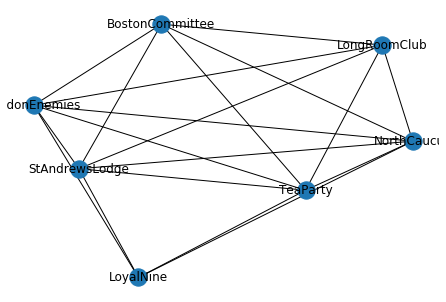

In [36]:
nx.draw_kamada_kawai(clubsG, with_labels=True)

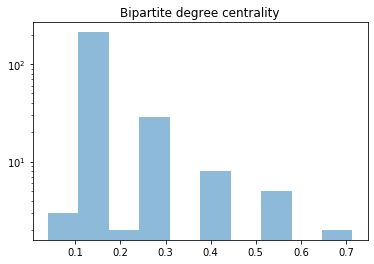

In [44]:
# Plot the degree centrality distribution of both node partitions from the original graph
plt.figure()
original_dc = nx.bipartite.degree_centrality(G, people)
plt.hist(list(original_dc.values()), alpha=0.5)
plt.yscale('log')
plt.title('Bipartite degree centrality')
plt.show()

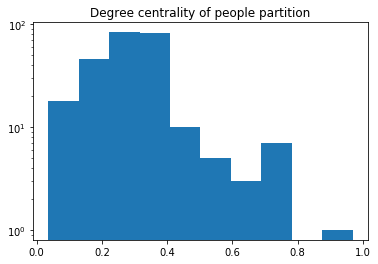

In [38]:
# Plot the degree centrality distribution of the peopleG graph
plt.figure()  
people_dc = nx.degree_centrality(peopleG)
plt.hist(list(people_dc.values()))
plt.yscale('log')
plt.title('Degree centrality of people partition')
plt.show()

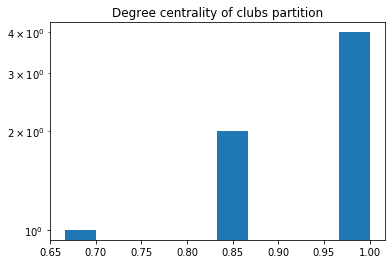

In [41]:

# Plot the degree centrality distribution of the clubsG graph
plt.figure() 
clubs_dc = nx.degree_centrality(clubsG)
plt.hist(list(clubs_dc.values()))
plt.yscale('log')
plt.title('Degree centrality of clubs partition')
plt.show()

#### Representing Bipartite Graphs as matrices

Matrix Representation
- Rows: nodes on one partition
- Columns: nodes on another partition
- Cells: 1 if edge present else 0

<p float="left">
    <img align="left" src="../../images/bipartite_example_projection.png" width="300" height="300">
    <img align="middle" src="../../images/matrix_rep_bipartite.png" width="200" height="200">
</p>

This matrix also known as the biadjacency matrix (as it is a bipartite graph) can be computed using the method
```python
networkx.bipartite.biadjacency_matrix(G, row_order, column_order)
```


One can indeed obtain the projection of one of the partitions by doing a matrix muliplication of the matrix representation with its'transpose

<img align="middle" src="../../images/projection_with_matrix_rep.png" width="800">

In [45]:
# Get nodes from partition function
def get_nodes_from_partition(G, partition):
    return [n for n, d in G.nodes(data=True) if d['bipartite'] == partition]

#### Getting the matrix representation of the projection graphs
Using the method mentioned before we can compute the biadjacency matrix of the graph G. We can use this to compute the matrix representation of the projection of the desired partition by multiplying the matrix with it's transpose. If we want to compute the projection of the users then we need to give the row orders as list of users and columns as list of clubs and vice versa in order to get the projection for the clubs. 

##### Projection of people

In [62]:
# Get the list of people and list of clubs from the graph: people_nodes, clubs_nodes
people_nodes = get_nodes_from_partition(G, 'people')
clubs_nodes = get_nodes_from_partition(G, 'clubs')

# Compute the biadjacency matrix: bi_matrix
bi_matrix = nx.bipartite.biadjacency_matrix(G, row_order=people_nodes, column_order=clubs_nodes)

# Compute the user-user projection: user_matrix
user_matrix = bi_matrix @ bi_matrix.T

print(user_matrix)

  (0, 250)	1
  (0, 231)	1
  (0, 197)	1
  (0, 180)	1
  (0, 166)	1
  (0, 135)	1
  (0, 101)	1
  (0, 83)	1
  (0, 70)	1
  (0, 67)	1
  (0, 60)	1
  (0, 59)	1
  (0, 253)	1
  (0, 251)	1
  (0, 241)	1
  (0, 235)	2
  (0, 232)	1
  (0, 229)	1
  (0, 227)	1
  (0, 226)	1
  (0, 224)	1
  (0, 223)	1
  (0, 222)	1
  (0, 221)	1
  (0, 209)	1
  :	:
  (253, 104)	1
  (253, 95)	2
  (253, 92)	2
  (253, 77)	1
  (253, 76)	1
  (253, 68)	2
  (253, 58)	2
  (253, 57)	2
  (253, 50)	2
  (253, 49)	1
  (253, 47)	1
  (253, 46)	2
  (253, 45)	1
  (253, 44)	1
  (253, 43)	1
  (253, 38)	1
  (253, 27)	1
  (253, 16)	1
  (253, 13)	2
  (253, 10)	3
  (253, 9)	1
  (253, 3)	2
  (253, 2)	1
  (253, 1)	2
  (253, 0)	1


#### Finding shared memberships

From the user matrix that we obtained above we shall now try to find
- Users who frequented more than one club
- Users who shared clubs
However the user matrix is actually a sparse matrix and we need to convert into a regular matrix before being able to use it.

In [63]:
# Use the diagonal to find out the users who went frequented the maximum number of clubs
diag = user_matrix.diagonal() 
indices = np.where(diag == diag.max())[0]  
print(f'Number of clubs: {diag.max()}')
print('People with the most number of memberships:')
for i in indices:
    print(f'- {people_nodes[i]}')


Number of clubs: 5
People with the most number of memberships:
- Revere.Paul
- Warren.Joseph


Now let us proceed to find customers with most shared clubs

In [67]:
# Set the diagonal elements = 0
user_matrix.setdiag(0)
# convert to coordinate matrix
users_coo = user_matrix.tocoo()

In [69]:
# Find pairs of users who shared membership in the most number of clubs
indices2 = np.where(users_coo.data == users_coo.data.max())[0]
print(f'Maximum shared membership: {users_coo.data.max()}')
print('People with most number of shared memberships:')
for idx in indices2:
    print('- {0}, {1}'.format(people_nodes[users_coo.row[idx]],
                              people_nodes[users_coo.col[idx]]))  

Maximum shared membership: 4
People with most number of shared memberships:
- Adams.Samuel, Warren.Joseph
- Adams.Samuel, Church.Benjamin
- Bass.Henry, Chase.Thomas
- Chase.Thomas, Bass.Henry
- Church.Benjamin, Warren.Joseph
- Church.Benjamin, Adams.Samuel
- Revere.Paul, Warren.Joseph
- Warren.Joseph, Revere.Paul
- Warren.Joseph, Church.Benjamin
- Warren.Joseph, Adams.Samuel


### Representing network data using pandas